# Final models

The purpose of this notebook is to collect "final versions" of the models we want to use for ensembling. These will all use the same data (though they can certainly omit columns if you want). The point is to go from zero-to-trained model in one notebook so we can make sure everything looks good.

In [114]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from utils.data_loader import Dataset

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.layers.experimental import preprocessing

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

## Data loading

Load the data here. Models below can augment it if need-be (for example the neural net needs it as a tensorflow dataset).

In [115]:
df = pd.read_csv('../data/Final Data/pct-diff-mlb-games.csv')  #Pct Diff Columns Only (Gives Highest Accuracy)
#df = pd.read_csv('../data/Final Data/diff-mlb-games.csv')    #Diff columns only
#df = pd.read_csv('../data/Final Data/full-diff-mlb-games.csv')    #All columns

train_df = df[df['Y'] <= 2015]
test_df = df[df['Y'] > 2015]

X_train = train_df.drop('home_win', axis=1)
y_train = train_df.home_win

X_test = test_df.drop('home_win', axis=1)
y_test = test_df.home_win

## Data cleaning

In [116]:
def fill_na_inf(df):
    for c in df.columns:
        if df[c].isin([-np.inf, np.inf]).sum() > 0:
            df[c] = df[c].replace([-np.inf, np.inf], None)
        if df[c].isna().sum() > 0:
            med = df[c].median()
            df[c] = df[c].fillna(med)
    return df

In [117]:
train_df = fill_na_inf(train_df)
test_df = fill_na_inf(test_df)

X_train = fill_na_inf(X_train)
X_test = fill_na_inf(X_test)

<ipython-input-116-88a5b3d15245>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].fillna(med)
<ipython-input-116-88a5b3d15245>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].replace([-np.inf, np.inf], None)


### Make tensorflow dataset from data

In [118]:
def load_ds(df):
    cols_to_drop = ['home_pitcher', 'away_pitcher', 'date']
    cols_to_drop = list(set(df.columns).intersection(set(cols_to_drop)))
    df = df.drop(cols_to_drop, axis='columns')
    
    embedding_cols = ['home_team', 'away_team', 'Y', 'M']
    numeric_cols = list(set(df.columns) - set(embedding_cols))
    numeric_cols.remove('home_win')
    assert set(numeric_cols).intersection(set(embedding_cols)) == set()
    assert len(embedding_cols) + len(numeric_cols) + 1 == len(df.columns)
    
    df = fill_na_inf(df)
            
    le = LabelEncoder()
    df['away_team'] = le.fit_transform(df['away_team'])
    df['home_team'] = le.transform(df['home_team'])
    
    for c in embedding_cols:
        df[c] = df[c].astype(int)
        
    assert df.isna().sum().sum() == 0
    
    y = df.pop('home_win')
    y = y.astype(int)
    X = df
    
    tf_ds = tf.data.Dataset.from_tensor_slices((dict(X), y)).batch(128)
    return tf_ds, df, le, embedding_cols, numeric_cols

In [119]:
train_ds, tf_train_df, le, embedding_cols, numeric_cols = load_ds(train_df)
test_ds, tf_test_df, _, _, _ = load_ds(test_df)

## Drop teams for all other models

In [120]:
X_train = X_train.drop(['home_team', 'away_team'], axis='columns')
X_test = X_test.drop(['home_team', 'away_team'], axis='columns')

train_df = train_df.drop(['home_team', 'away_team'], axis='columns')
test_df = test_df.drop(['home_team', 'away_team'], axis='columns')

## XGBoost

In [121]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

In [122]:
xgb_clf = xgb.XGBClassifier(**params)

In [123]:
xgb_clf.fit(X_train, y_train)

/Users/psavala/.virtualenvs/baseball/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [124]:
xgb_preds = xgb_clf.predict(X_test)
xgb_proba_preds = xgb_clf.predict_proba(X_test)

test_acc = accuracy_score(y_test, xgb_preds)
print(f'Test acc = {100*test_acc:.2f}%')

Test acc = 62.40%


In [125]:
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.62      0.52      0.57      4551
           1       0.63      0.71      0.67      5167

    accuracy                           0.62      9718
   macro avg       0.62      0.62      0.62      9718
weighted avg       0.62      0.62      0.62      9718



### Feature Importance

In [126]:
featuredf = pd.DataFrame(xgb_clf.feature_importances_, X_train.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=False)

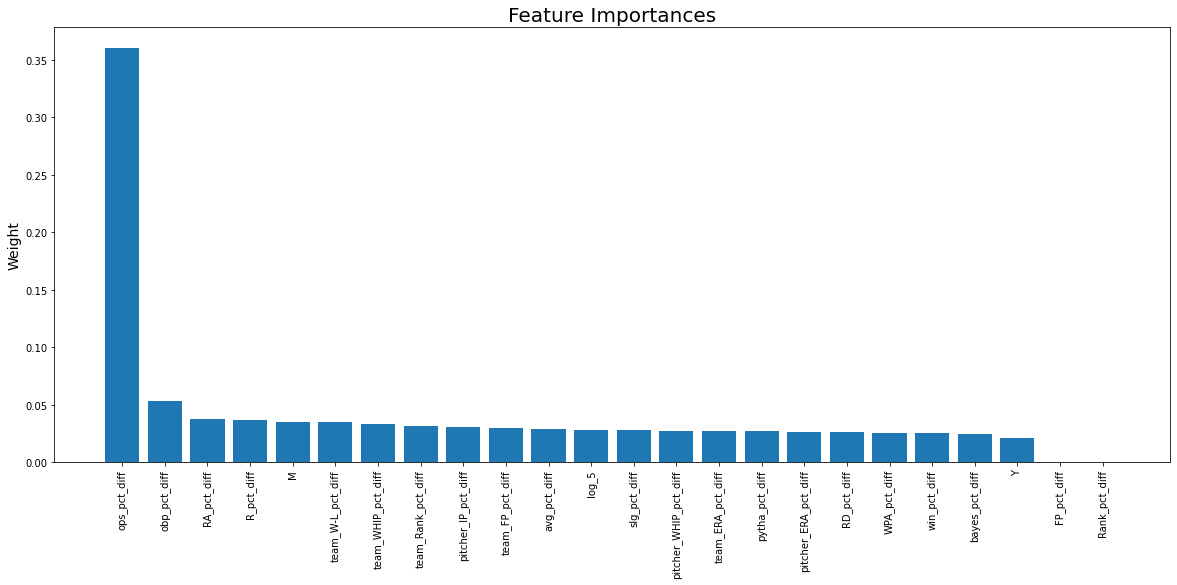

In [127]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14);

## KNN

In [128]:
ss = StandardScaler()
ss.fit(pd.concat([X_train, X_test]))
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [183]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

train_df_scaled = X_train_scaled.copy()
train_df_scaled['home_win'] = y_train

test_df_scaled = X_test_scaled.copy()
test_df_scaled['home_win'] = y_test

In [130]:
X_train_scaled.head()

,Y,M,avg_pct_diff,obp_pct_diff,slg_pct_diff,team_ERA_pct_diff,team_WHIP_pct_diff,team_W-L_pct_diff,team_Rank_pct_diff,team_FP_pct_diff,...,bayes_pct_diff,pitcher_WHIP_pct_diff,pitcher_ERA_pct_diff,pitcher_IP_pct_diff,ops_pct_diff,RD_pct_diff,FP_pct_diff,Rank_pct_diff,WPA_pct_diff,log_5
0,-1.643418,-1.479435,-0.112176,-0.177431,0.302918,-0.341462,-0.917199,0.752258,0.062973,1.702860,...,0.003164,0.043125,0.054297,0.05313,0.141951,-0.213058,1.702860,0.062973,0.00293,-0.000786
1,-1.643418,-1.479435,0.144850,0.010289,0.188294,1.383597,1.631203,-0.560841,0.746805,-0.282838,...,0.003164,0.043125,0.054297,0.05313,0.121344,0.015397,-0.282838,0.746805,0.00293,-0.000786
2,-1.643418,-1.479435,-0.172415,0.214475,-0.128371,0.219931,-0.149283,0.104822,0.336506,0.001576,...,0.003164,0.043125,0.054297,0.05313,-0.024132,-0.006120,0.001576,0.336506,0.00293,-0.000786
3,-1.643418,-1.479435,0.140878,-0.009936,0.283479,0.465188,0.978746,-0.422013,0.746805,0.853950,...,0.003164,0.043125,0.054297,0.05313,0.182743,-0.132778,0.853950,0.746805,0.00293,-0.000786
4,-1.643418,-1.479435,0.100441,0.226334,0.077746,0.296285,0.389461,-0.143961,0.746805,2.825569,...,0.003164,0.043125,0.054297,0.05313,0.122075,-0.090985,2.825569,0.746805,0.00293,-0.000786


In [131]:
knn_clf = KNeighborsClassifier(150)
knn_clf.fit(X_train_scaled, y_train)

knn_preds = knn_clf.predict(X_test_scaled)
knn_proba_preds = knn_clf.predict_proba(X_test_scaled)

accuracy_score(y_test, knn_preds)

0.6218357686766824

In [132]:
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.62      0.51      0.56      4551
           1       0.63      0.72      0.67      5167

    accuracy                           0.62      9718
   macro avg       0.62      0.62      0.61      9718
weighted avg       0.62      0.62      0.62      9718



## KNN without OPS, OBP, SLG, AVG

Try training KNN with `ops_pct_diff`, `obp_pct_diff`, `avg_pct_diff` and `slg_pct_diff` removed (all hitting stats).

In [202]:
X_train_scaled_no_ops = X_train_scaled.drop(['ops_pct_diff', 'obp_pct_diff', 'slg_pct_diff', 'avg_pct_diff'], axis='columns')
X_test_scaled_no_ops = X_test_scaled.drop(['ops_pct_diff', 'obp_pct_diff', 'slg_pct_diff', 'avg_pct_diff'], axis='columns')

In [203]:
knn_no_ops_clf = KNeighborsClassifier(150)
knn_no_ops_clf.fit(X_train_scaled_no_ops, y_train)

knn_no_ops_preds = knn_no_ops_clf.predict(X_test_scaled_no_ops)
knn_no_ops_proba_preds = knn_no_ops_clf.predict_proba(X_test_scaled_no_ops)

accuracy_score(y_test, knn_no_ops_preds)

0.5592714550318996

## Neural net

### Prepare layers

In [73]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a StringLookup layer which will turn strings into integer indices
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)
    
    if name == 'home_team':
        print('home_team')
        print(index.get_vocabulary())
        
    if name == 'away_team':
        print('away_team')
        print(index.get_vocabulary())

    # Create a Discretization for our integer indices.
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    # Prepare a Dataset that only yields our feature.
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices.
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices. The lambda function captures the
    # layer so we can use them, or include them in the functional model later.
    return lambda feature: encoder(index(feature))

def prep_columns(dataset, embedding_dims=10, embedding_cols=None, numeric_cols=None):
    cont_inputs = []
    cat_inputs = []
    encoded_cont_features = []
    encoded_cat_features = []
    if isinstance(embedding_dims, int):
        embedding_dims = [embedding_dims] * len(embedding_cols)
    assert len(embedding_dims) == len(embedding_cols), 'embedding_dims must be an integer or a list with the same length as embedding_cols'

    # Numeric features.
    for header in numeric_cols:
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, dataset)
        encoded_numeric_col = normalization_layer(numeric_col)
        encoded_numeric_col = tf.keras.layers.Dropout(0.1)(encoded_numeric_col)
        cont_inputs.append(numeric_col)
        encoded_cont_features.append(encoded_numeric_col)

    # Home and away teams
    for i, header in enumerate(['home_team', 'away_team']):
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoded_categorical_col = tf.keras.layers.Embedding(30, embedding_dims[i], name=f'{header}_embedding')(categorical_col)
        encoded_categorical_col = tf.keras.layers.Flatten()(encoded_categorical_col)
        cat_inputs.append(categorical_col)
        encoded_cat_features.append(encoded_categorical_col)
        
    # Categorical features encoded as ints.
    encoded_embedding_cols = embedding_cols.copy()
    encoded_embedding_cols.remove('home_team')
    encoded_embedding_cols.remove('away_team')
    for i, header in enumerate(encoded_embedding_cols):
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoding_layer = get_category_encoding_layer(header, dataset, 
                                                     dtype='int', 
                                                     max_tokens=20)
        encoded_categorical_col = encoding_layer(categorical_col)
        encoded_categorical_col = tf.keras.layers.Embedding(20, 5, name=f'{header}_embedding')(encoded_categorical_col)
        encoded_categorical_col = tf.keras.layers.Flatten()(encoded_categorical_col)
        cat_inputs.append(categorical_col)
        encoded_cat_features.append(encoded_categorical_col)
        
    all_inputs = cont_inputs + cat_inputs
        
    return all_inputs, encoded_cont_features, encoded_cat_features

In [74]:
all_inputs, encoded_cont_features, encoded_cat_features = prep_columns(train_ds,
                                                                       10,
                                                                       embedding_cols, 
                                                                       numeric_cols)

### Model

In [75]:
x = concatenate(encoded_cat_features + encoded_cont_features)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
output = Dense(1)(x)
try:
    del model
except NameError:
    pass
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [76]:
model.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
285/285 [==============================] - 4s 7ms/step - loss: 0.7227 - accuracy: 0.5489 - val_loss: 0.6515 - val_accuracy: 0.5711
Epoch 2/30
285/285 [==============================] - 2s 5ms/step - loss: 0.6621 - accuracy: 0.5781 - val_loss: 0.6478 - val_accuracy: 0.5912
Epoch 3/30
285/285 [==============================] - 2s 6ms/step - loss: 0.6556 - accuracy: 0.5796 - val_loss: 0.6477 - val_accuracy: 0.5930
Epoch 4/30
285/285 [==============================] - 2s 5ms/step - loss: 0.6505 - accuracy: 0.5896 - val_loss: 0.6463 - val_accuracy: 0.5858
Epoch 5/30
285/285 [==============================] - 1s 5ms/step - loss: 0.6503 - accuracy: 0.5834 - val_loss: 0.6462 - val_accuracy: 0.5874
Epoch 6/30
285/285 [==============================] - 2s 6ms/step - loss: 0.6483 - accuracy: 0.5878 - val_loss: 0.6453 - val_accuracy: 0.5910
Epoch 7/30
285/285 [==============================] - 1s 5ms/step - loss: 0.6462 - accuracy: 0.5886 - val_loss: 0.6454 - val_accuracy: 0.5930
Epoch 

In [77]:
loss, acc = model.evaluate(test_ds)
print(f'Test accuracy = {100*acc:.2f}%')

76/76 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.5943
Test accuracy = 59.43%


In [78]:
nn_logit_preds = model.predict(test_ds).squeeze()
nn_softmax_preds = tf.nn.sigmoid(nn_logit_preds)
nn_preds = tf.round(nn_softmax_preds).numpy()

## Monthly accuracy

Compare the monthly accuracy for all models.

In [79]:
def monthly_accuracy(model, df, is_tf=False):
    monthly_acc = []
    months_list = np.sort(df['M'].unique())
    for months in months_list:
        test_month = df[df['M'] == months]

        y_test_month = test_month.pop('home_win')
        X_test_month = test_month

        if is_tf:
            tf_ds = tf.data.Dataset.from_tensor_slices((dict(X_test_month), y_test_month)).batch(128)
            test_logits = model.predict(tf_ds).squeeze()
            pred = tf.round(tf.nn.sigmoid(test_logits)).numpy()
        else:
            pred = model.predict(X_test_month)
        acc = accuracy_score(y_test_month, pred)

        monthly_acc.append(acc)

    monthly_acc = pd.DataFrame(monthly_acc)
    
    return monthly_acc

In [184]:
xgb_month = monthly_accuracy(xgb_clf, test_df)
knn_month = monthly_accuracy(knn_clf, test_df_scaled)
knn_no_ops_month = monthly_accuracy(knn_no_ops_clf, test_df_scaled.drop('ops_pct_diff', axis=1))
tf_test_df['home_win'] = y_test
nn_month = monthly_accuracy(model, tf_test_df, is_tf=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

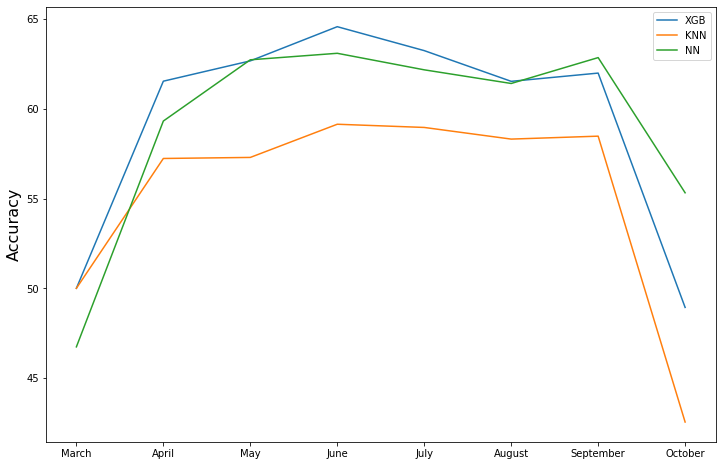

In [81]:
plt.figure(figsize=(12,8))
plt.plot(xgb_month[0]*100, label='XGB')
plt.plot(knn_month[0]*100, label='KNN')
plt.plot(nn_month[0]*100, label='NN')
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(range(8), ['March','April', 'May', 'June','July', 'August', 'September', 'October'])
plt.legend();

## Negative stats

Consider stats like `ops_pct_diff` where a positive value is a strong indicator of a win for the home team. In the case where these stats are _negative_ and yet the home team still wins (or positive but the away team wins), how is each model performing?

In [196]:
tf_test_df['home_win'] = y_test

In [197]:
tf_test_df.head()

,home_team,away_team,Y,M,avg_pct_diff,obp_pct_diff,slg_pct_diff,team_ERA_pct_diff,team_WHIP_pct_diff,team_W-L_pct_diff,...,log_5,xgb_pred,knn_pred,nn_pred,xgb_proba,knn_proba,nn_proba,home_win,knn_no_ops_pred,knn_no_ops_proba
36441,KCA,NYN,2016,4,8.620726,3.092675,2.578581,7.754011,8.007859,5.263158,...,0.5,1,1,1,0.562908,0.533333,0.590414,1,1,0.533333
36442,PIT,SLN,2016,4,2.309712,0.376945,-0.040732,8.978328,-1.211283,-2.040816,...,0.5,1,0,1,0.533676,0.493333,0.563689,1,1,0.506667
36443,TBA,TOR,2016,4,-5.864577,-7.555239,-12.023378,-1.871658,1.468752,-16.250000,...,0.5,0,1,1,0.454400,0.566667,0.666198,0,1,0.593333
36444,ANA,CHN,2016,4,0.398896,-4.950458,-0.794957,14.720812,8.900281,-14.117647,...,0.5,0,0,1,0.450952,0.460000,0.531114,0,0,0.420000
36445,ARI,COL,2016,4,-1.095675,2.427164,-5.196744,-24.444444,-13.778463,13.924051,...,0.5,1,0,1,0.584152,0.446667,0.562535,0,0,0.466667


In [204]:
def negative_stats_acc(df, col, reverse=False):
    if not reverse:
        unusual_df = df[((df[col] > 0) & (df['home_win'] == 0)) | ((df[col] < 0) & (df['home_win'] == 1))]
    else:
        unusual_df = df[((df[col] < 0) & (df['home_win'] == 0)) | ((df[col] > 0) & (df['home_win'] == 1))]
    
    xgb_acc = (unusual_df['xgb_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    nn_acc = (unusual_df['nn_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    knn_acc = (unusual_df['knn_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    knn_no_ops_acc = (unusual_df['knn_no_ops_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    
    print(f'{"="*10} {col} {"="*10}')
    print(f'XGB acc = {100*xgb_acc:.2f}%')
    print(f'NN acc = {100*nn_acc:.2f}%')
    print(f'KNN acc = {100*knn_acc:.2f}%')
    print(f'KNN (no OPS) acc = {100*knn_no_ops_acc:.2f}%')

In [205]:
reverse_cols = ['team_ERA_pct_diff', 'pitcher_ERA_pct_diff', 'team_WHIP_pct_diff',
                'pitcher_WHIP_pct_diff', 'team_Rank_pct_diff', 'Rank_pct_diff']
pct_diff_cols = [c for c in tf_test_df.columns if c.endswith('_pct_diff')]

In [206]:
for c in reverse_cols:
    pct_diff_cols.remove(c)

In [207]:
for c in pct_diff_cols:
    negative_stats_acc(tf_test_df, c)

========== avg_pct_diff ==========
XGB acc = 31.32%
NN acc = 26.86%
KNN acc = 27.62%
KNN (no OPS) acc = 27.29%
========== obp_pct_diff ==========
XGB acc = 26.99%
NN acc = 24.87%
KNN acc = 24.55%
KNN (no OPS) acc = 24.76%
========== slg_pct_diff ==========
XGB acc = 27.15%
NN acc = 22.95%
KNN acc = 25.77%
KNN (no OPS) acc = 27.76%
========== team_W-L_pct_diff ==========
XGB acc = 51.64%
NN acc = 55.34%
KNN acc = 48.38%
KNN (no OPS) acc = 48.10%
========== team_FP_pct_diff ==========
XGB acc = 59.50%
NN acc = 61.55%
KNN acc = 57.47%
KNN (no OPS) acc = 57.61%
========== R_pct_diff ==========
XGB acc = 54.32%
NN acc = 54.22%
KNN acc = 49.10%
KNN (no OPS) acc = 48.97%
========== RA_pct_diff ==========
XGB acc = 70.13%
NN acc = 67.08%
KNN acc = 70.99%
KNN (no OPS) acc = 71.23%
========== pytha_pct_diff ==========
XGB acc = 50.92%
NN acc = 53.32%
KNN acc = 47.52%
KNN (no OPS) acc = 47.26%
========== win_pct_diff ==========
XGB acc = 52.21%
NN acc = 53.85%
KNN acc = 48.41%
KNN (no OPS) acc = 

In [208]:
for c in reverse_cols:
    negative_stats_acc(tf_test_df, c, reverse=True)

========== team_ERA_pct_diff ==========
XGB acc = 53.05%
NN acc = 55.55%
KNN acc = 49.51%
KNN (no OPS) acc = 49.21%
========== pitcher_ERA_pct_diff ==========
XGB acc = 61.37%
NN acc = 59.52%
KNN acc = 61.23%
KNN (no OPS) acc = 61.41%
========== team_WHIP_pct_diff ==========
XGB acc = 53.26%
NN acc = 55.71%
KNN acc = 50.12%
KNN (no OPS) acc = 49.77%
========== pitcher_WHIP_pct_diff ==========
XGB acc = 56.96%
NN acc = 57.73%
KNN acc = 56.55%
KNN (no OPS) acc = 56.22%
========== team_Rank_pct_diff ==========
XGB acc = 50.88%
NN acc = 55.41%
KNN acc = 47.78%
KNN (no OPS) acc = 47.39%
========== Rank_pct_diff ==========
XGB acc = 50.88%
NN acc = 55.41%
KNN acc = 47.78%
KNN (no OPS) acc = 47.39%


## Ensembling

In [82]:
assert xgb_preds.shape == knn_preds.shape == nn_preds.shape == y_test.shape

In [210]:
print('Individual model accuracy:')
print(f'XGB: {100*accuracy_score(y_test, xgb_preds):.2f}%')
print(f'KNN: {100*accuracy_score(y_test, knn_preds):.2f}%')
print(f'KNN (no hitting): {100*accuracy_score(y_test, knn_no_ops_preds):.2f}%')
print(f'NN: {100*accuracy_score(y_test, nn_preds):.2f}%')       

Individual model accuracy:
XGB: 62.40%
KNN: 62.18%
KNN (no hitting): 55.93%
NN: 61.78%


### Maximum possible accuracy

If we could always pick the "right" model for each row, what is the best possible test accuracy we could get from these three models?

In [212]:
num_correct = 0

for i in range(y_test.shape[0]):
    if y_test.values[i] in [xgb_preds[i], knn_no_ops_preds[i], nn_preds[i]]:
        num_correct += 1

print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Maximum possible accuracy = 81.89%


### Majority voting

Just pick the prediction that the majority of the models voted for.

In [213]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    majority_vote = np.sum([xgb_preds[i], knn_no_ops_preds[i], nn_preds[i]])
    if majority_vote > 1:
        majority_vote = 1
    else:
        majority_vote = 0
    if y_test.values[i] == majority_vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Majority voting accuracy = 62.37%


## Recording predictions

Save a dataframe with the predictions for each model.

In [214]:
tf_test_df.head()

,home_team,away_team,Y,M,avg_pct_diff,obp_pct_diff,slg_pct_diff,team_ERA_pct_diff,team_WHIP_pct_diff,team_W-L_pct_diff,...,log_5,xgb_pred,knn_pred,nn_pred,xgb_proba,knn_proba,nn_proba,home_win,knn_no_ops_pred,knn_no_ops_proba
36441,KCA,NYN,2016,4,8.620726,3.092675,2.578581,7.754011,8.007859,5.263158,...,0.5,1,1,1,0.562908,0.533333,0.590414,1,1,0.533333
36442,PIT,SLN,2016,4,2.309712,0.376945,-0.040732,8.978328,-1.211283,-2.040816,...,0.5,1,0,1,0.533676,0.493333,0.563689,1,1,0.506667
36443,TBA,TOR,2016,4,-5.864577,-7.555239,-12.023378,-1.871658,1.468752,-16.250000,...,0.5,0,1,1,0.454400,0.566667,0.666198,0,1,0.593333
36444,ANA,CHN,2016,4,0.398896,-4.950458,-0.794957,14.720812,8.900281,-14.117647,...,0.5,0,0,1,0.450952,0.460000,0.531114,0,0,0.420000
36445,ARI,COL,2016,4,-1.095675,2.427164,-5.196744,-24.444444,-13.778463,13.924051,...,0.5,1,0,1,0.584152,0.446667,0.562535,0,0,0.466667


In [215]:
tf_test_df['home_team'] = le.inverse_transform(tf_test_df['home_team'])
tf_test_df['away_team'] = le.inverse_transform(tf_test_df['away_team'])

ValueError: y contains previously unseen labels: ['ANA' 'ARI' 'ATL' 'BAL' 'BOS' 'CHA' 'CHN' 'CIN' 'CLE' 'COL' 'DET' 'HOU'
 'KCA' 'LAN' 'MIA' 'MIL' 'MIN' 'NYA' 'NYN' 'OAK' 'PHI' 'PIT' 'SDN' 'SEA'
 'SFN' 'SLN' 'TBA' 'TEX' 'TOR' 'WAS']

In [135]:
tf_test_df.head()

,home_team,away_team,Y,M,avg_pct_diff,obp_pct_diff,slg_pct_diff,team_ERA_pct_diff,team_WHIP_pct_diff,team_W-L_pct_diff,...,bayes_pct_diff,pitcher_WHIP_pct_diff,pitcher_ERA_pct_diff,pitcher_IP_pct_diff,ops_pct_diff,RD_pct_diff,FP_pct_diff,Rank_pct_diff,WPA_pct_diff,log_5
36441,KCA,NYN,2016,4,8.620726,3.092675,2.578581,7.754011,8.007859,5.263158,...,-0.0,-0.304643,2.121464,0.0,2.805262,15.662651,-0.101523,0.000000,96.381239,0.5
36442,PIT,SLN,2016,4,2.309712,0.376945,-0.040732,8.978328,-1.211283,-2.040816,...,-0.0,-0.304643,2.121464,0.0,0.147930,-20.792079,-0.305810,50.000000,96.381239,0.5
36443,TBA,TOR,2016,4,-5.864577,-7.555239,-12.023378,-1.871658,1.468752,-16.250000,...,-0.0,-0.304643,2.121464,0.0,-10.063876,-10950.000000,-0.101626,75.000000,96.381239,0.5
36444,ANA,CHN,2016,4,0.398896,-4.950458,-0.794957,14.720812,8.900281,-14.117647,...,-0.0,-0.304643,2.121464,0.0,-2.616367,678.571429,0.203252,0.000000,96.381239,0.5
36445,ARI,COL,2016,4,-1.095675,2.427164,-5.196744,-24.444444,-13.778463,13.924051,...,-0.0,-0.304643,2.121464,0.0,-1.831024,1628.571429,0.101420,-66.666667,96.381239,0.5


In [216]:
tf_test_df['xgb_pred'] = xgb_preds
tf_test_df['knn_pred'] = knn_preds
tf_test_df['knn_no_batting_pred'] = knn_no_ops_preds
tf_test_df['nn_pred'] = nn_preds
tf_test_df['nn_pred'] = tf_test_df['nn_pred'].astype(int)

tf_test_df['xgb_proba'] = xgb_proba_preds[:, 1]
tf_test_df['knn_proba'] = knn_proba_preds[:, 1]
tf_test_df['knn_no_batting_proba'] = knn_no_ops_proba_preds[:, 1]
tf_test_df['nn_proba'] = nn_softmax_preds.numpy()

In [217]:
tf_test_df.head()

,home_team,away_team,Y,M,avg_pct_diff,obp_pct_diff,slg_pct_diff,team_ERA_pct_diff,team_WHIP_pct_diff,team_W-L_pct_diff,...,knn_pred,nn_pred,xgb_proba,knn_proba,nn_proba,home_win,knn_no_ops_pred,knn_no_ops_proba,knn_no_batting_pred,knn_no_batting_proba
36441,KCA,NYN,2016,4,8.620726,3.092675,2.578581,7.754011,8.007859,5.263158,...,1,1,0.562908,0.533333,0.590414,1,1,0.533333,1,0.566667
36442,PIT,SLN,2016,4,2.309712,0.376945,-0.040732,8.978328,-1.211283,-2.040816,...,0,1,0.533676,0.493333,0.563689,1,1,0.506667,1,0.513333
36443,TBA,TOR,2016,4,-5.864577,-7.555239,-12.023378,-1.871658,1.468752,-16.250000,...,1,1,0.454400,0.566667,0.666198,0,1,0.593333,1,0.613333
36444,ANA,CHN,2016,4,0.398896,-4.950458,-0.794957,14.720812,8.900281,-14.117647,...,0,1,0.450952,0.460000,0.531114,0,0,0.420000,0,0.500000
36445,ARI,COL,2016,4,-1.095675,2.427164,-5.196744,-24.444444,-13.778463,13.924051,...,0,1,0.584152,0.446667,0.562535,0,0,0.466667,0,0.500000


In [218]:
tf_test_df.to_csv('../data/Final Data/pct-diff-mlb-games-with-preds.csv', index=False)